In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [115]:
acc= pd.read_csv("Accelerometer.csv")
gra= pd.read_csv("Gravity.csv")
loc= pd.read_csv("Location.csv")


In [116]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110680 entries, 0 to 110679
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             110680 non-null  int64  
 1   seconds_elapsed  110680 non-null  float64
 2   z                110680 non-null  float64
 3   y                110680 non-null  float64
 4   x                110680 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.2 MB


In [117]:
gra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110680 entries, 0 to 110679
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             110680 non-null  int64  
 1   seconds_elapsed  110680 non-null  float64
 2   z                110680 non-null  float64
 3   y                110680 non-null  float64
 4   x                110680 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.2 MB


In [118]:
columns_to_check = ["time", "seconds_elapsed"]

missing_cols = [col for col in columns_to_check if col not in acc.columns or col not in gra.columns]
if missing_cols:
    print("Columns are missing :",missing_cols)
else:
    min_len = min(len(acc), len(gra))
    acc = acc.iloc[:min_len].reset_index(drop=True)
    gra = gra.iloc[:min_len].reset_index(drop=True)
    for col in columns_to_check:
        acc_col = acc[col]
        gra_col = gra[col]
        comparison = (acc_col == gra_col)
        print(f"Column Name : {col}")
        print(f"Matches : {comparison.sum()}")
        print(f"Mismatches : {(~comparison).sum()}")
        mismatches = pd.DataFrame({
            "acc": acc_col[~comparison],
            "gra": gra_col[~comparison]
        })
        if not mismatches.empty:
            print("Mismatched rows (top 5):")
            print(mismatches.head())


Column Name : time
Matches : 110680
Mismatches : 0
Column Name : seconds_elapsed
Matches : 110680
Mismatches : 0


In [119]:

merge_keys = ["time", "seconds_elapsed"]

for key in merge_keys:
    if key not in acc.columns or key not in gra.columns:
        raise KeyError(f"Merge key '{key}' missing in one of the files.")

# 4. Rename all non-key columns to include file name suffix
acc_renamed = acc.rename(columns={col: col + "_acc" for col in acc.columns if col not in merge_keys})
gra_renamed = gra.rename(columns={col: col + "_gra" for col in gra.columns if col not in merge_keys})


merged_df = pd.merge(acc_renamed, gra_renamed, on=merge_keys, how="outer")

print("Merged DataFrame preview:")
merged_df


Merged DataFrame preview:


,time,seconds_elapsed,z_acc,y_acc,x_acc,z_gra,y_gra,x_gra
0,1724757563935217000,0.360217,-0.047415,-0.960002,-0.756141,9.176506,3.457155,-0.100983
1,1724757563951268900,0.376269,0.934132,-0.535097,-1.229317,9.274744,3.180690,-0.180868
2,1724757563967290400,0.392290,2.036102,-0.499270,-0.563352,9.314808,3.058672,-0.221946
3,1724757563983250700,0.408251,1.835670,-0.334245,0.967719,9.359616,2.915194,-0.263823
4,1724757563999211300,0.424211,0.531980,0.193473,1.535954,9.401564,2.772943,-0.302940
...,...,...,...,...,...,...,...,...
110675,1724759330307095300,1766.732095,-0.049727,-0.028813,-0.332934,9.760610,-0.488335,-0.813889
110676,1724759330323055600,1766.748056,-0.412272,0.204853,-0.498230,9.764025,-0.458639,-0.789850
110677,1724759330338985500,1766.763985,-0.748174,0.816741,-0.727464,9.769526,-0.443246,-0.728210
110678,1724759330354945800,1766.779946,-0.601881,0.520581,-0.536502,9.774068,-0.472697,-0.643840


In [120]:
# Convert time columns to numeric or datetime
acc['time'] = pd.to_numeric(acc['time'])
gra['time'] = pd.to_numeric(gra['time'])
loc['time'] = pd.to_numeric(loc['time'])

# Merge accelerometer + gravity first
merged_df = pd.merge_asof(
    acc.sort_values('time'),
    gra.sort_values('time'),
    on='time',
    suffixes=('_acc', '_gra')
)

# Merge location with nearest timestamp
merged_df = pd.merge_asof(
    merged_df.sort_values('time'),
    loc.sort_values('time'),
    on='time'
)

print("Final merged_df shape:", merged_df.shape)


Final merged_df shape: (110680, 19)


In [121]:
merged_df

,time,seconds_elapsed_acc,z_acc,y_acc,x_acc,seconds_elapsed_gra,z_gra,y_gra,x_gra,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,1724757563935217000,0.360217,-0.047415,-0.960002,-0.756141,0.360217,9.176506,3.457155,-0.100983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1724757563951268900,0.376269,0.934132,-0.535097,-1.229317,0.376269,9.274744,3.180690,-0.180868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1724757563967290400,0.392290,2.036102,-0.499270,-0.563352,0.392290,9.314808,3.058672,-0.221946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1724757563983250700,0.408251,1.835670,-0.334245,0.967719,0.408251,9.359616,2.915194,-0.263823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1724757563999211300,0.424211,0.531980,0.193473,1.535954,0.424211,9.401564,2.772943,-0.302940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110675,1724759330307095300,1766.732095,-0.049727,-0.028813,-0.332934,1766.732095,9.760610,-0.488335,-0.813889,1757.856,45.0,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605
110676,1724759330323055600,1766.748056,-0.412272,0.204853,-0.498230,1766.748056,9.764025,-0.458639,-0.789850,1757.856,45.0,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605
110677,1724759330338985500,1766.763985,-0.748174,0.816741,-0.727464,1766.763985,9.769526,-0.443246,-0.728210,1757.856,45.0,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605
110678,1724759330354945800,1766.779946,-0.601881,0.520581,-0.536502,1766.779946,9.774068,-0.472697,-0.643840,1757.856,45.0,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605


In [122]:
location=pd.read_csv('Location.csv')

In [123]:
merged_df.shape

(110680, 19)

In [124]:
merged_df['Total Acceleration'] = np.sqrt(merged_df['x_acc']**2 + merged_df['y_acc']**2 + merged_df['z_acc']**2)
merged_df['Total Gravity'] = np.sqrt(merged_df['x_gra']**2 + merged_df['y_gra']**2 + merged_df['z_gra']**2)


In [125]:
merged_df.describe()

,time,seconds_elapsed_acc,z_acc,y_acc,x_acc,seconds_elapsed_gra,z_gra,y_gra,x_gra,seconds_elapsed,...,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude,Total Acceleration,Total Gravity
count,1.106800e+05,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110672.000000,...,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110680.000000,110680.000000
mean,1.724758e+18,883.634467,0.102595,-0.026916,0.048055,883.634467,-7.370637,-3.251607,-2.692995,882.909549,...,0.495356,6.729955,19.548776,4.732409,134.394166,527.618863,73.768144,18.564894,1.646350,9.806651
std,5.099426e+11,509.942591,1.693148,1.479306,1.265594,509.942591,2.838451,3.048873,2.582002,509.454938,...,0.417050,5.210424,79.853055,5.348674,71.533124,24.490154,0.007058,0.016317,1.989947,0.000001
min,1.724758e+18,0.360217,-70.113670,-87.444885,-36.744316,0.360217,-9.800465,-9.806635,-9.126412,0.479000,...,0.010000,1.000000,1.583000,0.000000,0.000000,493.000000,73.749979,18.544821,0.007762,9.806647
25%,1.724758e+18,442.017082,-0.415722,-0.495253,-0.407662,442.017082,-9.142226,-5.879175,-4.710048,441.477546,...,0.270000,3.000000,3.000000,0.430017,113.026329,512.000000,73.765628,18.555315,0.624936,9.806650
50%,1.724758e+18,883.651968,0.088058,0.038051,0.033166,883.651968,-8.402553,-2.991665,-3.777900,883.480147,...,0.370000,4.000000,3.400000,2.558809,158.997696,519.000000,73.768646,18.562075,1.155707,9.806651
75%,1.724759e+18,1325.260542,0.624429,0.476476,0.476583,1325.260542,-6.545834,-0.803013,-0.361283,1324.692000,...,0.530000,8.500401,4.000000,7.286280,162.004105,536.700012,73.771052,18.569764,1.965057,9.806653
max,1.724759e+18,1766.795937,80.759979,34.131962,56.302879,1766.795937,9.776037,9.275198,9.803483,1757.856000,...,2.220000,33.513546,854.325012,20.079790,357.084778,606.599976,73.782118,18.610212,120.565977,9.806657


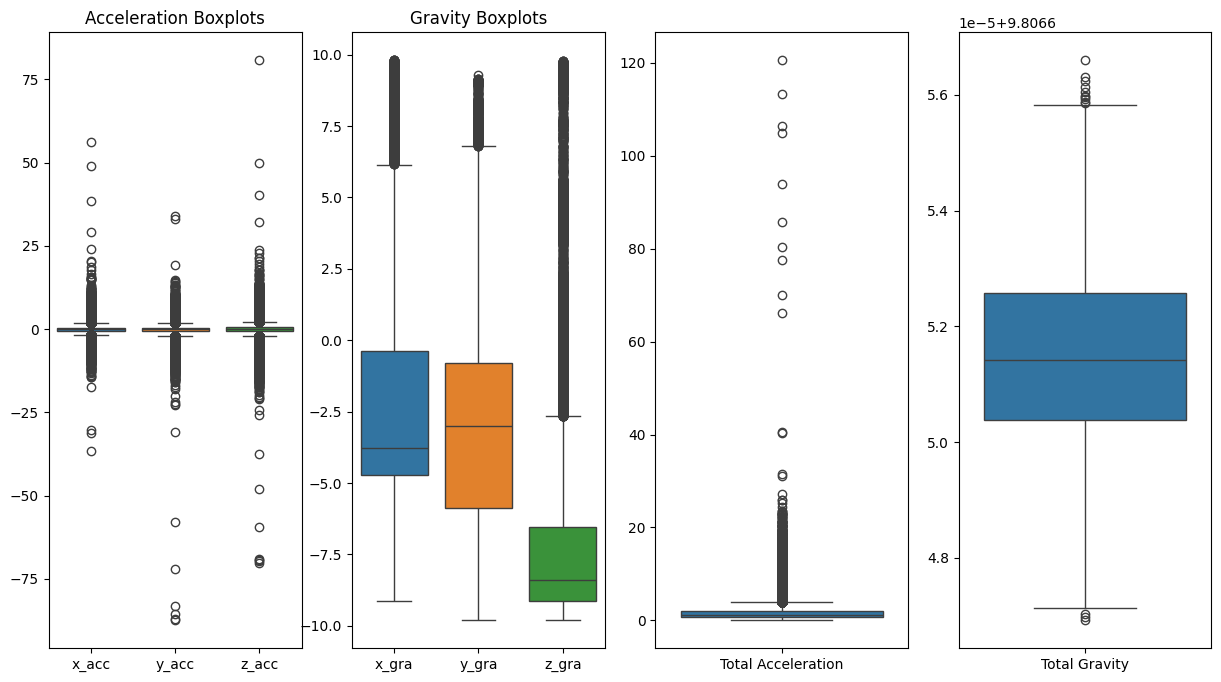

In [126]:
plt.figure(figsize=(15, 8))
plt.subplot(1,4,1)
sns.boxplot(data= merged_df[['x_acc', 'y_acc', 'z_acc']])
plt.title('Acceleration Boxplots')
plt.subplot(1,4,2)
sns.boxplot(data= merged_df[['x_gra', 'y_gra', 'z_gra']])
plt.title('Gravity Boxplots')
plt.subplot(1,4,3)
sns.boxplot(data= merged_df[['Total Acceleration']])
plt.subplot(1,4,4)
sns.boxplot(data= merged_df[['Total Gravity']])
plt.show()

Text(0.5, 1.0, 'Acceleration Boxplots')

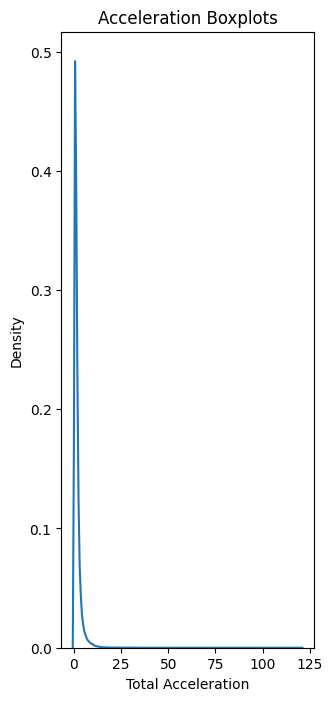

In [127]:
plt.figure(figsize=(15, 8))
plt.subplot(1,4,1)
sns.kdeplot(merged_df['Total Acceleration'])
plt.title('Acceleration Boxplots')

In [128]:
merged_df['Total Acceleration'] = merged_df['Total Acceleration']

In [129]:
from sklearn.preprocessing import MinMaxScaler
std_scl = MinMaxScaler()
col=['x_acc','y_acc','z_acc','x_gra','y_gra','z_gra','Total Acceleration','Total Gravity']
merged_df[col]=std_scl.fit_transform(merged_df[col])

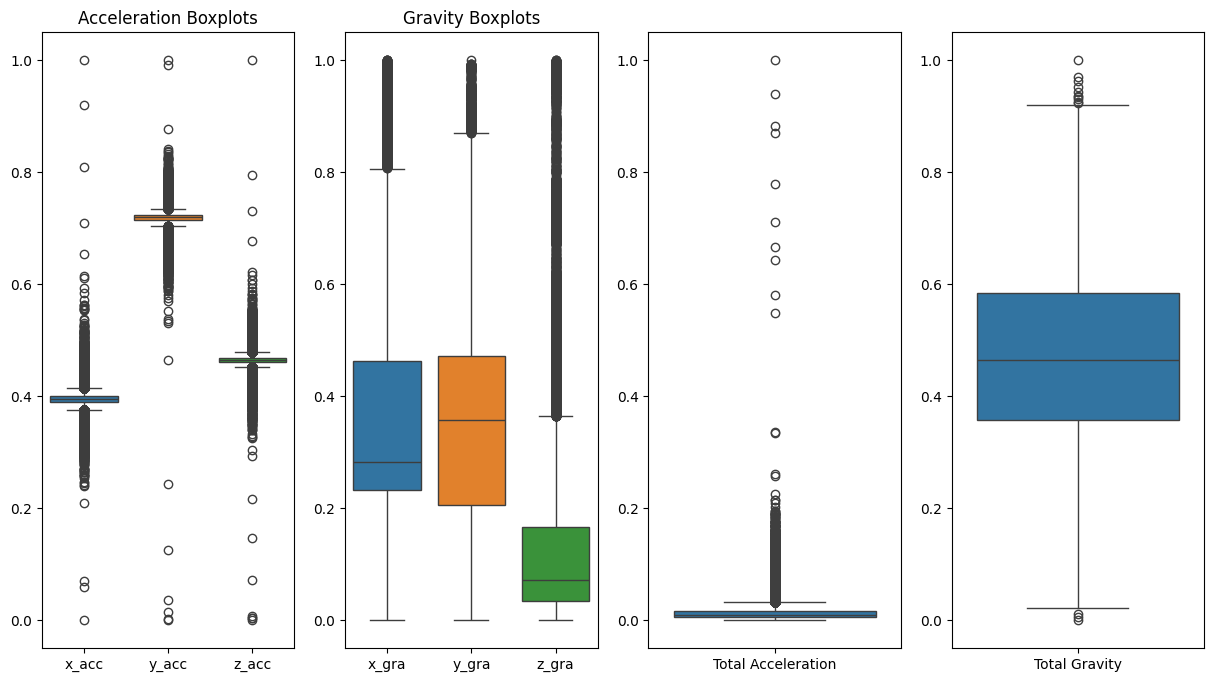

In [130]:
plt.figure(figsize=(15, 8))
plt.subplot(1,4,1)
sns.boxplot(data= merged_df[['x_acc', 'y_acc', 'z_acc']])
plt.title('Acceleration Boxplots')
plt.subplot(1,4,2)
sns.boxplot(data= merged_df[['x_gra', 'y_gra', 'z_gra']])
plt.title('Gravity Boxplots')
plt.subplot(1,4,3)
sns.boxplot(data= merged_df[['Total Acceleration']])
plt.subplot(1,4,4)
sns.boxplot(data= merged_df[['Total Gravity']])
plt.show()

In [131]:
columns = ['x_acc', 'y_acc', 'z_acc','x_gra', 'y_gra', 'z_gra','Total Acceleration','Total Gravity']

for col in columns:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    merged_df[col] = merged_df[col].apply(
    lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
)


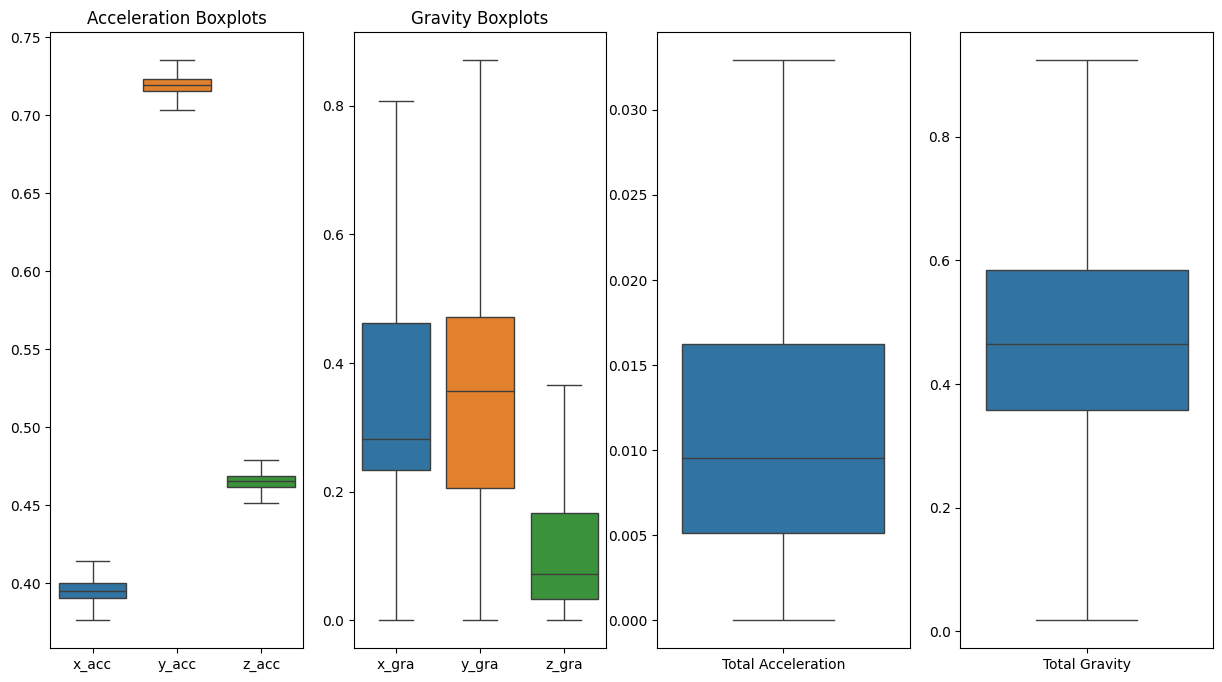

In [132]:
plt.figure(figsize=(15, 8))
plt.subplot(1,4,1)
sns.boxplot(data= merged_df[['x_acc', 'y_acc', 'z_acc']])
plt.title('Acceleration Boxplots')
plt.subplot(1,4,2)
sns.boxplot(data= merged_df[['x_gra', 'y_gra', 'z_gra']])
plt.title('Gravity Boxplots')
plt.subplot(1,4,3)
sns.boxplot(data= merged_df[['Total Acceleration']])
plt.subplot(1,4,4)
sns.boxplot(data= merged_df[['Total Gravity']])
plt.show()

In [133]:
merged_df.describe()

,time,seconds_elapsed_acc,z_acc,y_acc,x_acc,seconds_elapsed_gra,z_gra,y_gra,x_gra,seconds_elapsed,...,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude,Total Acceleration,Total Gravity
count,1.106800e+05,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110680.000000,110672.000000,...,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110672.000000,110680.000000,110680.000000
mean,1.724758e+18,883.634467,0.465424,0.719207,0.395326,883.634467,0.110611,0.343357,0.338482,882.909549,...,0.495356,6.729955,19.548776,4.732409,134.394166,527.618863,73.768144,18.564894,0.011983,0.471703
std,5.099426e+11,509.942591,0.006510,0.007528,0.008798,509.942591,0.100220,0.159195,0.130927,509.454938,...,0.417050,5.210424,79.853055,5.348674,71.533124,24.490154,0.007058,0.016317,0.008996,0.154043
min,1.724758e+18,0.360217,0.451621,0.703193,0.376264,0.360217,0.000000,0.000000,0.000000,0.479000,...,0.010000,1.000000,1.583000,0.000000,0.000000,493.000000,73.749979,18.544821,0.000000,0.017906
25%,1.724758e+18,442.017082,0.461962,0.715182,0.390519,442.017082,0.033624,0.205822,0.233301,441.477546,...,0.270000,3.000000,3.000000,0.430017,113.026329,512.000000,73.765628,18.555315,0.005119,0.357574
50%,1.724758e+18,883.651968,0.465301,0.719569,0.395256,883.651968,0.071408,0.357144,0.282543,883.480147,...,0.370000,4.000000,3.400000,2.558809,158.997696,519.000000,73.768646,18.562075,0.009522,0.464778
75%,1.724759e+18,1325.260542,0.468857,0.723175,0.400022,1325.260542,0.166252,0.471843,0.463031,1324.692000,...,0.530000,8.500401,4.000000,7.286280,162.004105,536.700012,73.771052,18.569764,0.016235,0.584020
max,1.724759e+18,1766.795937,0.479198,0.735164,0.414276,1766.795937,0.365194,0.870874,0.807626,1757.856000,...,2.220000,33.513546,854.325012,20.079790,357.084778,606.599976,73.782118,18.610212,0.032909,0.923688


In [134]:
from sklearn.preprocessing import Normalizer
std_scl = Normalizer(norm='l1')
col=['x_acc','y_acc','z_acc','x_gra','y_gra','z_gra']
merged_df[col]=std_scl.fit_transform(merged_df[col])

In [135]:
merged_df

,time,seconds_elapsed_acc,z_acc,y_acc,x_acc,seconds_elapsed_gra,z_gra,y_gra,x_gra,seconds_elapsed,...,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude,Total Acceleration,Total Gravity
0,1724757563935217000,0.360217,0.149826,0.229500,0.124781,0.360217,0.117819,0.224254,0.153820,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010080,0.294816
1,1724757563951268900,0.376269,0.152604,0.231658,0.123691,0.376269,0.118346,0.220561,0.153140,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013490,0.301083
2,1724757563967290400,0.392290,0.154661,0.231289,0.125758,0.392290,0.118109,0.218051,0.152131,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017942,0.297547
3,1724757563983250700,0.408251,0.153895,0.231223,0.130794,0.408251,0.117851,0.215150,0.151086,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017370,0.282292
4,1724757563999211300,0.424211,0.151484,0.233205,0.133096,0.424211,0.118146,0.213275,0.150794,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013514,0.321392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110675,1724759330307095300,1766.732095,0.161956,0.250758,0.136474,1766.732095,0.127362,0.170307,0.153144,1757.856,...,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605,0.002738,0.327515
110676,1724759330323055600,1766.748056,0.161086,0.251379,0.135827,1766.748056,0.127336,0.170816,0.153556,1757.856,...,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605,0.005562,0.358405
110677,1724759330338985500,1766.763985,0.160064,0.252745,0.134761,1766.763985,0.127141,0.170834,0.154454,1757.856,...,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605,0.010927,0.326369
110678,1724759330354945800,1766.779946,0.160206,0.251591,0.135311,1766.779946,0.126986,0.170090,0.155816,1757.856,...,1.5,1.072652,20.615,0.212526,84.429665,606.599976,73.77907,18.546605,0.007896,0.269327


In [136]:
columns = ['Total Acceleration','Total Gravity']

for col in columns:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    merged_df[col] = merged_df[col].apply(
    lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
)


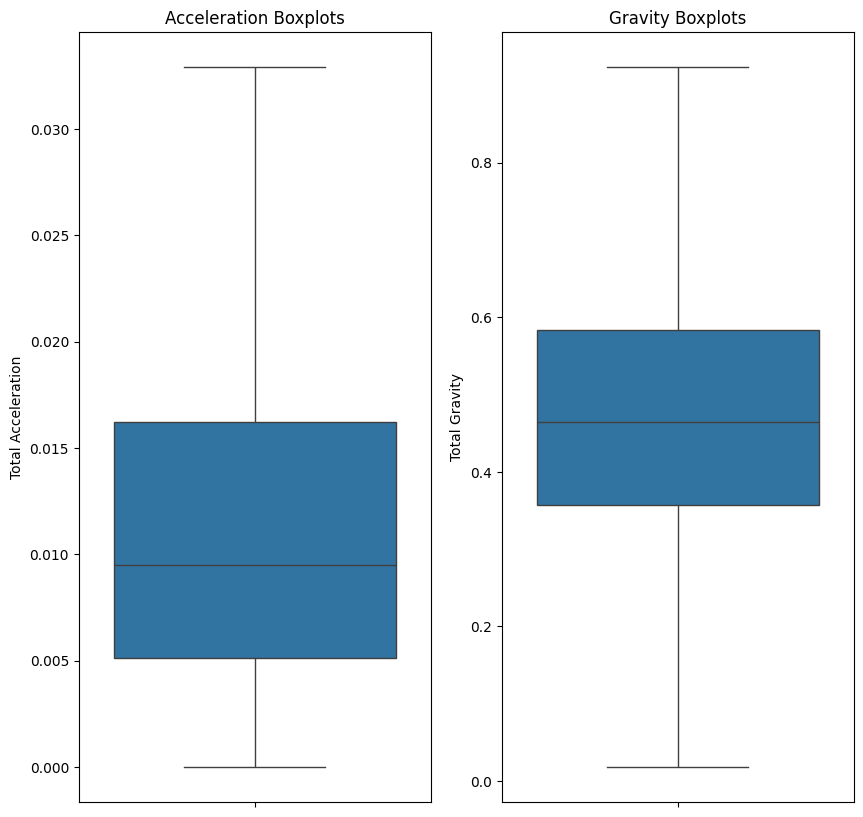

In [137]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
sns.boxplot(data= merged_df['Total Acceleration'])
plt.title('Acceleration Boxplots')
plt.subplot(1,2,2)
sns.boxplot(data= merged_df['Total Gravity'])
plt.title('Gravity Boxplots')
plt.show()

<Axes: >

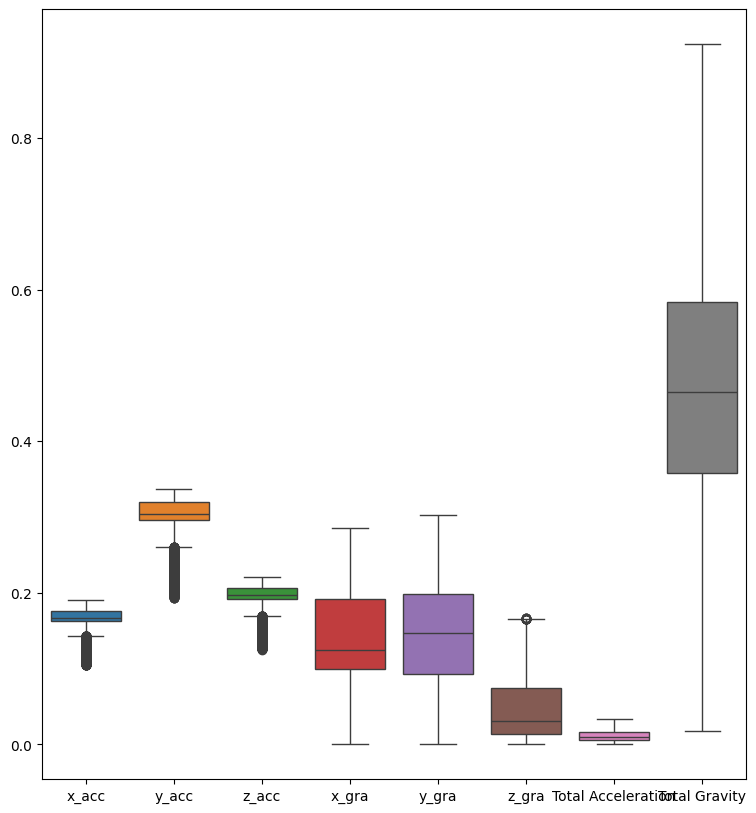

In [138]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.boxplot(data= merged_df[['x_acc','y_acc','z_acc','x_gra','y_gra','z_gra','Total Acceleration','Total Gravity']])

In [139]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium

try:
   
    # # # # # # # # # # # # --- 3. K-Means Clustering Pipeline ---
    features = [
        'z_acc', 'y_acc', 'x_acc',
        'speed', 'altitude', 'Total Acceleration'
    ]
    
    existing_features = [col for col in features if col in merged_df.columns]
    
    X = merged_df[existing_features].fillna(merged_df[existing_features].mean())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    merged_df['cluster'] = kmeans.fit_predict(X_scaled)
    print("K-Means clustering complete.")

    # --- 4. Interpret Clusters and Create Labels ---
    analysis_df = X.copy()
    analysis_df['cluster'] = merged_df['cluster']
    cluster_means = analysis_df.groupby('cluster')[['Total Acceleration']].mean().sort_values('Total Acceleration')

    cluster_labels = {
        cluster_means.index[0]: 'Smooth Road',
        cluster_means.index[1]: 'Moderate Road',
        cluster_means.index[2]: 'Rough Road'
    }
    merged_df['road_condition'] = merged_df['cluster'].map(cluster_labels)
    print("Cluster labels assigned: Smooth, Moderate, Rough.")

    # --- 5. Map Visualization with Folium ---
    map_df = merged_df.dropna(subset=['latitude', 'longitude', 'road_condition'])
    
    # Downsample the data to plot every 50th point for better map performance
    map_df_sampled = map_df.iloc[::50, :]

    if not map_df_sampled.empty:
        # Center the map on the average coordinates
        map_center = [map_df_sampled['latitude'].mean(), map_df_sampled['longitude'].mean()]
        road_map = folium.Map(location=map_center, zoom_start=14, tiles='CartoDB positron')

        # Define a color scheme for the conditions
        color_map = {
            'Smooth Road': 'green',
            'Moderate Road': 'orange',
            'Rough Road': 'red'
        }

        # Add points to the map
        for index, row in map_df_sampled.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=4,
                color=color_map.get(row['road_condition'], 'blue'),
                fill=True,
                fill_color=color_map.get(row['road_condition'], 'blue'),
                fill_opacity=0.7,
                popup=f"Condition: {row['road_condition']}<br>Speed: {row['speed']:.2f} m/s"
            ).add_to(road_map)

        # Save the map to an HTML file
        map_filename = 'road_conditions_map.html'
        road_map.save(map_filename)
        print(f"\nSUCCESS: Interactive map has been generated and saved as '{map_filename}'.")
    else:
        print("\nNOTE: No location data was available after processing to generate a map.")

except FileNotFoundError as e:
    print(f"Error: A required CSV file was not found. Please ensure Accelerometer.csv, Gravity.csv, and Location.csv are in the same folder as this script. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

K-Means clustering complete.
Cluster labels assigned: Smooth, Moderate, Rough.

SUCCESS: Interactive map has been generated and saved as 'road_conditions_map.html'.
